In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')

In [4]:
df.shape

(169, 2)

In [5]:
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [6]:
df.rename(columns={'Monthly milk production: pounds per cow. Jan 62 ? Dec 75': 'Milk produced'}, inplace=True)

In [7]:
df.head()

,Month,Milk produced
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [8]:
df.tail()

,Month,Milk produced
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


In [9]:
df.drop(168, axis=0, inplace=True)

In [10]:
df.tail()

,Month,Milk produced
163,1975-08,858.0
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0


In [11]:
df['Month'] = pd.to_datetime(df['Month'])

In [12]:
df.set_index('Month', inplace=True)

In [13]:
df.tail()

,Milk produced
Month,
1975-08-01,858.0
1975-09-01,817.0
1975-10-01,827.0
1975-11-01,797.0
1975-12-01,843.0


In [14]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk produced,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


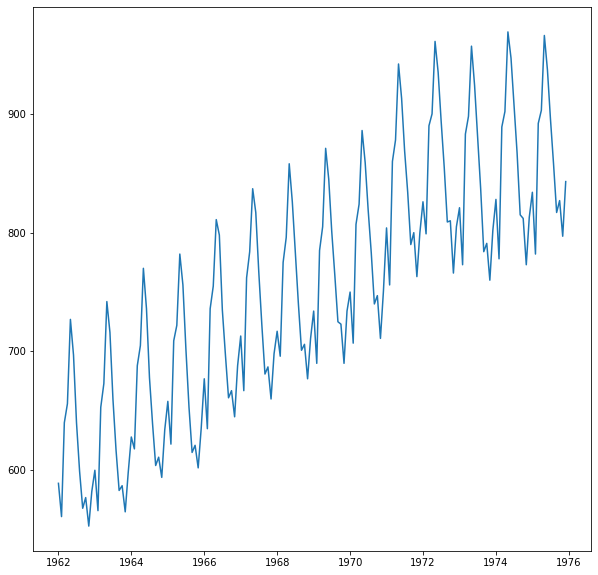

In [15]:
plt.figure(figsize=(10, 10))
plt.plot(df['Milk produced'])

In [16]:
timeseries = df['Milk produced']

In [17]:
type(timeseries)

pandas.core.series.Series

<AxesSubplot:xlabel='Month'>

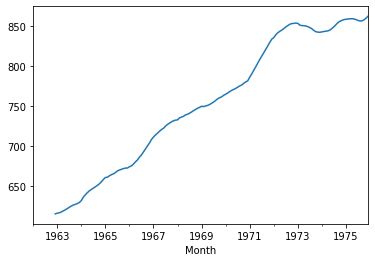

In [18]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean') # to identify the trend

<AxesSubplot:xlabel='Month'>

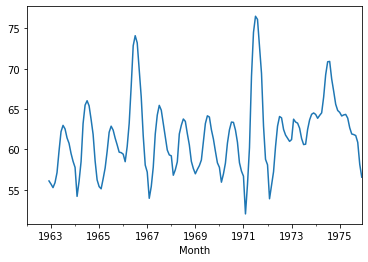

In [19]:
timeseries.rolling(12).std().plot(label='12 Month Rolling Std') # Plotting the average std (Just for visualization)

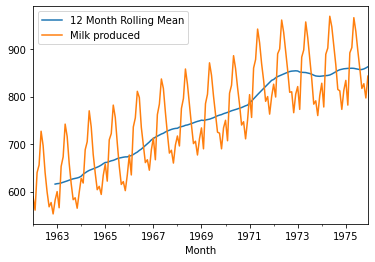

In [20]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.plot()
plt.legend()

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose # Classical decomposition

In [22]:
decomposition = seasonal_decompose(df['Milk produced'], period = 12)

<Figure size 432x288 with 0 Axes>

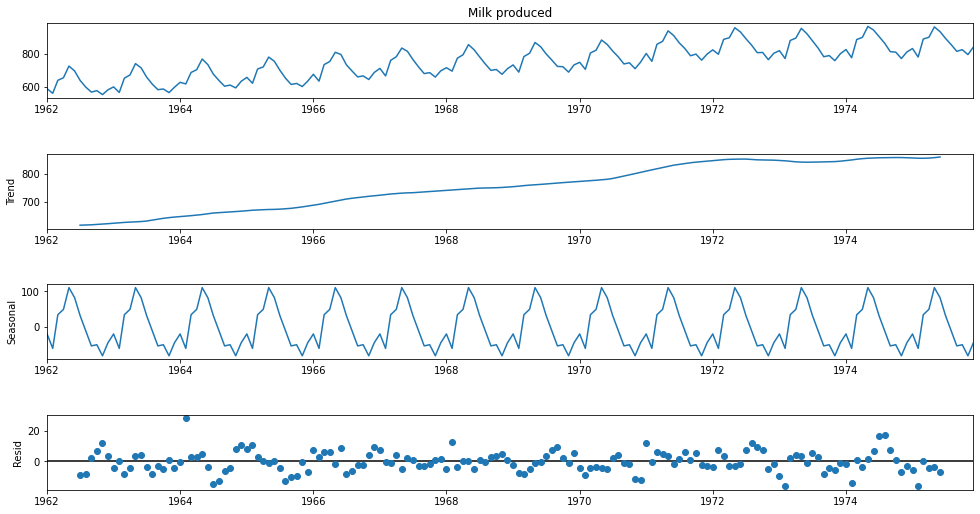

In [23]:
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [24]:
df.head()

,Milk produced
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [25]:
from statsmodels.tsa.stattools import adfuller # Importing Augmented Dickey Fuller

In [26]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augumented-Dickey-Fuller Test:')
    labels = ['ADF Test Statistic',
             'p-value',
             '#Lags Used',
             'Number of Observations Used']
    
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))
        
    if result[1] <= 0.05:
        print('strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary')
    else:
        print('weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary')

In [27]:
result = adf_check(timeseries)

Augumented-Dickey-Fuller Test:
ADF Test Statistic : -1.3038115874221345
p-value : 0.6274267086030293
#Lags Used : 13
Number of Observations Used : 154
weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary


In [28]:
df['Milk produced'] # y(t)

Month
1962-01-01    589.0
1962-02-01    561.0
1962-03-01    640.0
1962-04-01    656.0
1962-05-01    727.0
              ...  
1975-08-01    858.0
1975-09-01    817.0
1975-10-01    827.0
1975-11-01    797.0
1975-12-01    843.0
Name: Milk produced, Length: 168, dtype: float64

In [29]:
df['Milk produced'].shift(1) # y(t-1)

Month
1962-01-01      NaN
1962-02-01    589.0
1962-03-01    561.0
1962-04-01    640.0
1962-05-01    656.0
              ...  
1975-08-01    896.0
1975-09-01    858.0
1975-10-01    817.0
1975-11-01    827.0
1975-12-01    797.0
Name: Milk produced, Length: 168, dtype: float64

<AxesSubplot:xlabel='Month'>

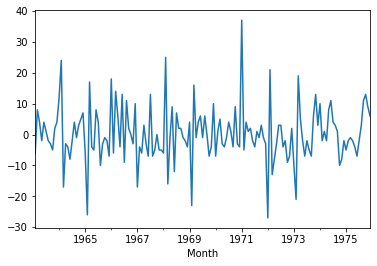

In [30]:
trend_removed = df['Milk produced'] - df['Milk produced'].shift(1) # First order normal differencing

trend_seasonality_removed = trend_removed - trend_removed.shift(12) # First order seasonal differencing

trend_seasonality_removed = trend_seasonality_removed.dropna()

trend_seasonality_removed.plot()

In [31]:
print(adf_check(trend_seasonality_removed))

Augumented-Dickey-Fuller Test:
ADF Test Statistic : -5.03800227492198
p-value : 1.865423431878859e-05
#Lags Used : 11
Number of Observations Used : 143
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary
None


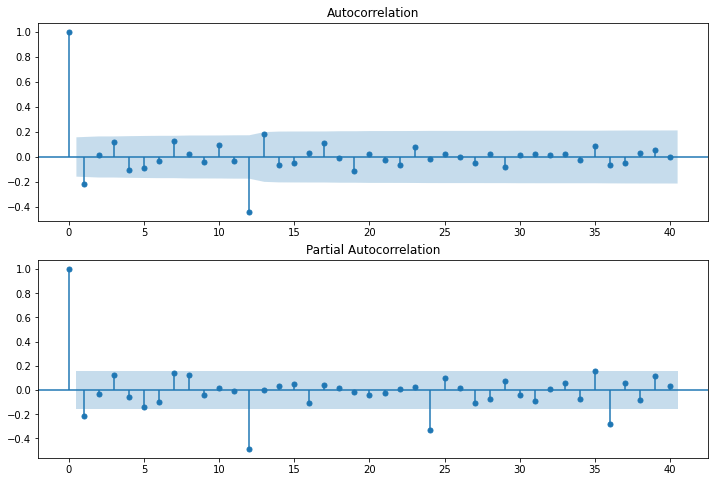

In [32]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(trend_seasonality_removed, lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(trend_seasonality_removed, lags = 40, ax = ax2)

In [33]:
# from statsmodels.tsa.arima_model import ARIMA

In [34]:
model = sm.tsa.statespace.SARIMAX(df['Milk produced'], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [35]:
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      Milk produced   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -530.032
Date:                            Sun, 19 Jun 2022   AIC                           1068.064
Time:                                    02:06:49   BIC                           1080.238
Sample:                                01-01-1962   HQIC                          1073.009
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1346      0.334     -0.403      0.687      -0.790       0.520
ma.L1         -0.0969      0.334   

<AxesSubplot:xlabel='Month'>

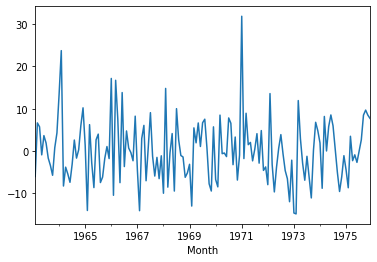

In [36]:
results.resid[13:].plot()

In [37]:
results.predict(start=118, end=128, dynamic=True) # forecast the value for 118th month using the model

1971-11-01    767.584612
1971-12-01    807.284820
1972-01-01    840.511015
1972-02-01    798.193423
1972-03-01    895.783725
1972-04-01    914.251865
1972-05-01    977.021790
1972-06-01    949.750495
1972-07-01    905.109981
1972-08-01    867.678280
1972-09-01    826.030549
Freq: MS, Name: predicted_mean, dtype: float64

<AxesSubplot:xlabel='Month'>

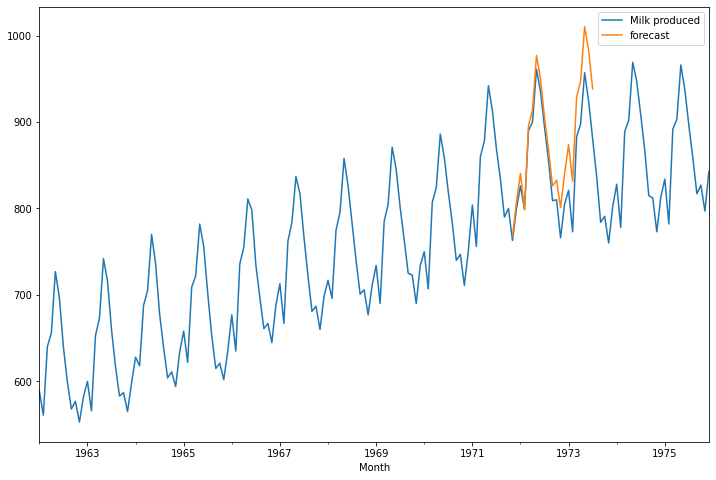

In [38]:
df['forecast'] = results.predict(start=118, end=138, dynamic=True)
df[['Milk produced', 'forecast']].plot(figsize=(12, 8))

In [39]:
df.tail()

,Milk produced,forecast
Month,,
1975-08-01,858.0,NaN
1975-09-01,817.0,NaN
1975-10-01,827.0,NaN
1975-11-01,797.0,NaN
1975-12-01,843.0,NaN


In [40]:
results.predict(start=168, end=180, dynamic=True)

1976-01-01     865.157934
1976-02-01     818.123460
1976-03-01     924.769670
1976-04-01     937.844772
1976-05-01    1000.986405
1976-06-01     973.578611
1976-07-01     932.217973
1976-08-01     892.628355
1976-09-01     846.735285
1976-10-01     851.902863
1976-11-01     817.864913
1976-12-01     860.132438
1977-01-01     883.256320
Freq: MS, Name: predicted_mean, dtype: float64

In [41]:
from pandas.tseries.offsets import DateOffset

In [42]:
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(0, 14)]

In [43]:
future_dates

[Timestamp('1975-12-01 00:00:00'),
 Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00')]

In [44]:
future_dates_df = pd.DataFrame(index=future_dates[1:], columns=df.columns)

In [45]:
future_df = pd.concat([df, future_dates_df])

In [46]:
future_df.tail()

,Milk produced,forecast
1976-09-01,NaN,NaN
1976-10-01,NaN,NaN
1976-11-01,NaN,NaN
1976-12-01,NaN,NaN
1977-01-01,NaN,NaN


<AxesSubplot:>

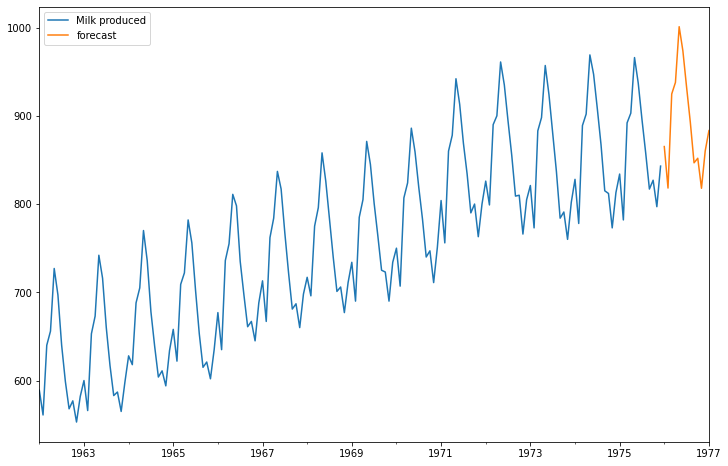

In [47]:
future_df['forecast'] = results.predict(start=168, end=180, dynamic=True)
future_df[['Milk produced', 'forecast']].plot(figsize = (12, 8))